# SimMobility visualization - Activities

Author: Lukas Ralf Schinzel, Master student at Technical University of Denmark (DTU)

**1. Information on Kepler GL Kupyter**

Documentation and installation of Kepler GL for Jupyter: https://docs.kepler.gl/docs/keplergl-jupyter  
User guide Kepler GL: https://docs.kepler.gl/docs/user-guides  
It is recommended to use Kepler GL for Jupyter in a Jupyter Notebook, not in Jupyter Lab.

**2. Visualization concept**

This visualization aims to examine how activities shift when changing from one SimMobility scenario to another. It uses a grid plot to display changes in activity for each spatial unit. Animating the visualization with a time slider will provide insights into when these shifts happen during the day. A bar chart provides additional information, disclosing a possible change in citizens’ preferred means of transport for reaching an activity.  
The user is offered two options: a view of activity changes aggregated for the entire day in the form of a static visualization, and an animated visualization that shows the percentage change in activities over the 24 hours of the day.  

The only input required by the user is to specify the input parameters in section 6. Other than that, it is only expected to rerun the notebook for each new visualization or when input parameters are changed.

The default configuration for the visualization in Kepler GL is saved in a Python script, which is automatically loaded from a configuration file when the visualization is created. The visualization can be adjusted using Kepler GL’s user interface.

**3. Required data**
- DAS (daily activity schedule)
- Nodes (network)

**4. Libraries**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
%matplotlib inline
from keplergl import KeplerGl

**5. Functions**

In [2]:
def load_das(filepath:str):
    
    '''Loads DAS from CSV into pandas data frame (for 18 million entries takes around 3 min to run).'''
    
    # define date types
    dtypes_das = {'person_id': 'str', 'tour_no': 'int64', 'tour_type': 'str', 'stop_no': 'int64', 'stop_type': 'str', 'stop_location': 'str', 'stop_zone': 'str', 'stop_mode': 'str',
                  'primary_stop': 'str', 'arrival_time': 'str', 'departure_time': 'str', 'prev_stop_location': 'str', 'prev_stop_zone': 'str', 'prev_stop_departure_time': 'str'}
    
    datetime_cols_das = ['arrival_time', 'departure_time', 'prev_stop_departure_time']
    
    # load DAS
    df_das = pd.read_csv(filepath, dtype=dtypes_das)
    
    # correct datetime formats
    random_seed = 0
    randomize = False
    for col in datetime_cols_das:
        # correct hours
        df_das[col] = df_das[col].str.replace('24.', '0.', regex = True)
        df_das[col] = df_das[col].str.replace('25.', '1.', regex = True)
        df_das[col] = df_das[col].str.replace('26.', '2.', regex = True)
        
        # convert fractional hours to minutes
        df_das[col] = df_das[col].str.replace('.25', '.15', regex = True)
        df_das[col] = df_das[col].str.replace('.75', '.45', regex = True)
                              
        # convert to datetime
        df_das[col] = pd.to_datetime(df_das[col], format = '%H.%M')
        df_das[col] = pd.to_datetime(df_das[col], format = '%H.%M')
    
    # convert primary stop column to boolean
    p = {'t': True, 'f': False}
    df_das['primary_stop'].map(p)
    
    return df_das

In [3]:
def get_activities(df_das):
    
    # reduce DAS to relevant columns
    activity_columns = ['person_id',# person ID, CURRENTLY NOT USED
                        'stop_type', # activity
                        'stop_location', # node
                        'stop_zone', # zone, CURRENTLY NOT USED
                        'stop_mode', # transport mode
                        'arrival_time']
    df_das = df_das[activity_columns]
    df_das.loc[:,'stop_location'] = df_das['stop_location'].astype(str)
    
    # get correct person ID that corresponds to the one in population table NECESSARY?
    df_das.loc[:,'person_id'] = df_das['person_id'].str.split('-', expand=True)[0] # remove digits after the dash
    df_das.loc[:,'person_id'] = df_das['person_id'].str[0:9] # reduce person ID to 9 digit number (rest assumed to not describe the person but a trip/subtrip)
    
    # rename columns 
    df_activities = df_das.rename(columns = {'stop_location': 'node_id'})
    
    return df_activities

In [4]:
def get_activity_differences_per_node(df_activities_A, df_activities_B, df_nodes, filter_activity = None):
    
    '''Intakes activity data and aggregates it to hourly data per node.'''
    
    # filter activity
    if filter_activity != None:
        df_activities_A = df_activities_A[df_activities_A['stop_type'] == filter_activity]
        df_activities_B = df_activities_B[df_activities_B['stop_type'] == filter_activity]
    
    # round to hourly steps
    df_activities_A.loc[:,'hour'] = df_activities_A.loc[:,'arrival_time'].dt.floor('H')
    df_activities_B.loc[:,'hour'] = df_activities_B.loc[:,'arrival_time'].dt.floor('H')
    
    # calculate activity stats
    df_activities_A_counts = pd.DataFrame(data=df_activities_A.groupby(['node_id','hour']).size(), columns=['count_A'])#[100:] # USE STOP_ZONE INSTEAD OF NODE_ID AS SOON AS ZONES ARE AVAILABLE
    df_activities_B_counts = pd.DataFrame(data=df_activities_B.groupby(['node_id','hour']).size(), columns=['count_B'])#[:-100] # USE STOP_ZONE INSTEAD OF NODE_ID AS SOON AS ZONES ARE AVAILABLE
    
    # concatenate the two activity dataframes
    df_activity_changes = pd.concat([df_activities_A_counts, df_activities_B_counts], axis=1).fillna(0)
    
    # calculate percentage change for each node
    df_activity_changes.loc[:,'delta_count'] = (df_activity_changes['count_B'] - df_activity_changes['count_A'])
    df_activity_changes.loc[:,'delta_count_[%]'] = (df_activity_changes['count_B'] - df_activity_changes['count_A'])*100 / df_activity_changes['count_A']
    
    # replace infinite values with NaN (from: https://stackoverflow.com/questions/17477979/dropping-infinite-values-from-dataframes-in-pandas)
    df_activity_changes.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # reduce nodes to relevant columns and rename # NOT NEEDED
    node_columns = ['id',
                    'x', # longitude
                    'y'] # latitude
    df_nodes = df_nodes[node_columns]
    df_nodes.loc[:,'id'] = df_nodes.loc[:,'id'].astype(str)
    df_nodes = df_nodes.rename(columns = {'x': 'longitude', 'y': 'latitude'})
    #df_nodes = df_nodes.set_index('node_id')

    # add location data on activity dataframe
    df_activity_changes = df_activity_changes.join(other = df_nodes.set_index('id'), on = 'node_id', how='left')
    
    return df_activity_changes

In [5]:
def get_percentage_mode_changes_for_activities(df_activities_A, df_activities_B, filter_activity = None):
    
    # filter activity
    if filter_activity != None:
        df_activities_A = df_activities_A[df_activities_A['stop_type'] == filter_activity]
        df_activities_B = df_activities_B[df_activities_B['stop_type'] == filter_activity]
    
    # calculate activity stats
    df_activities_A_stats = pd.DataFrame(data=df_activities_A.groupby('stop_mode').size(), columns=['count'])
    df_activities_B_stats = pd.DataFrame(data=df_activities_B.groupby('stop_mode').size(), columns=['count'])
    df_activities_A_stats['percentage_share'] = df_activities_A_stats['count']/sum(df_activities_A_stats['count'])*100
    df_activities_B_stats['percentage_share'] = df_activities_B_stats['count']/sum(df_activities_B_stats['count'])*100
    
    # join dataframes
    df_activities_stats = df_activities_A_stats.join(other = df_activities_B_stats, lsuffix = '_A', rsuffix = '_B')
    
    # create bar plot
    df_activities_stats.plot(y = ['percentage_share_B', 'percentage_share_A'], kind = 'barh',
                             color = [(0.77, 0.0, 0.05), (0, 0, 0.4)], legend = 'reverse',
                             label = ['Mode share scenario B', 'Mode share scenario A'])
    plt.xlabel('Percentage share [%]')
    plt.ylabel('')
    plt.title('Transport modes used to reach the activit{}'.format('ies' if filter_activity == None else str('y ' + filter_activity)))
    plt.show()
    
    return df_activities_stats

In [6]:
def load_nodes(filepath_nodes:str, epsg):

    '''Loads node data from CSV.'''
    
    # load data
    df_nodes = pd.read_csv(filepath_nodes)
    df_nodes['id'] = df_nodes['id'].astype(str)
    
    # combine x and y coordinates to shapely point
    df_nodes['geometry'] = [Point(xy) for xy in zip(df_nodes.x, df_nodes.y)]
    
    # convert to geopandas data frame
    #df_nodes = gpd.GeoDataFrame(df_nodes, geometry='geometry')
    
    # set and convert CRS
    #df_nodes = df_nodes.set_crs(epsg=str(epsg))
    #df_nodes = df_nodes.to_crs(epsg='4326') # necessary if correct CRS is set above?
    
    return df_nodes

In [7]:
def adjust_to_hourly_activity_changes(df_activity_changes):
    
    '''Adding min and max to each hour in order to enable consistent colour scaling.
    Necessary until colour scale value customization possible in Kepler GL
    (see: https://github.com/keplergl/kepler.gl/issues/399).'''
    
    # select a random node containing all 24h
    df_add = None
    ok = False
    while ok == False:
        rand_int = np.random.randint(0,len(df_activity_changes)/24)
        random_node = df_activity_changes.index.get_level_values('node_id')[rand_int]
        df_add = df_activity_changes[df_activity_changes.index.get_level_values('node_id') == random_node]
        if len(df_add) == 24:
            ok = True

    df_add_min = df_add.copy()
    df_add_max = df_add.copy()

    for col in ['count_A','count_B','delta_count','delta_count_[%]']:
        min_value = df_activity_changes[col].min()
        max_value = df_activity_changes[col].max()

        df_add_min[col] = min_value
        df_add_max[col] = max_value

    # determine random location
    df_add_min['longitude'] = -70.0
    df_add_max['longitude'] = -70.0
    df_add_min['latitude'] = 41.0
    df_add_max['latitude'] = 42.0

    # change indices to not create a duplicate
    #df_add_min.index = df_add_min.index.set_levels(levels=['999999998'],level=0) # replaces the first index level (node id) with '999999998'
    #df_add_max.index = df_add_max.index.set_levels(levels=['999999999'],level=0) # replaces the first index level (node id) with '999999999'

    # add these two atificial nodes to data frame
    df_activity_changes_2 = df_activity_changes.append(df_add_min)#, verify_integrity=True)
    df_activity_changes_3 = df_activity_changes_2.append(df_add_max)#, verify_integrity=True)
    
    return df_activity_changes_3

**6. Create visualization**

Specify filepaths for data:

In [8]:
# DAS for scenario A and B
filepath_das_A = '../Data/Boston/DTU/Boston_Lukas/das_base_1104.csv'
filepath_das_B = '../Data/Boston/DTU/Boston_Lukas/das_cordontoll1204.csv'

# nodes
filepath_nodes = '../Data/Boston/DTU/Boston_Lukas/node_wgs84.csv'

Specify activity (either 'Work', 'Shop', 'Other' or None):

In [28]:
filter_activity = 'Work'

Specify aggregation:
- 'day' for static visualization
- 'hour' for animated visualization of the 24 hours of the day

In [15]:
aggregation = 'day'

Specify EPSG in which zones are stored:

In [11]:
epsg = '4326'

**7. Create visualization:**

In [12]:
# load data
df_das_A = load_das(filepath_das_A)
df_das_B = load_das(filepath_das_B)
df_nodes = load_nodes(filepath_nodes, epsg=epsg)

In [13]:
# get activities
df_activities_A = get_activities(df_das = df_das_A)
df_activities_B = get_activities(df_das = df_das_B)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [29]:
# get activity changes
df_activity_changes = get_activity_differences_per_node(df_activities_A,
                                                        df_activities_B,
                                                        df_nodes, filter_activity = filter_activity)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [30]:
# restrict increase in activity changes to 100% to ensure consistent colouring
# (necessary until colour scale value customization possible in Kepler GL, see: https://github.com/keplergl/kepler.gl/issues/399)

df_activity_changes['delta_count_[%]'][df_activity_changes['delta_count_[%]'] > 100] = 100

In [31]:
# adding min an max to each hour in order to enable consistent colour scaling
# (necessary until colour scale value customization possible in Kepler GL, see: https://github.com/keplergl/kepler.gl/issues/399)

df_activity_changes_3 = adjust_to_hourly_activity_changes(df_activity_changes)

In [32]:
# load the map configuration saved

# for aggregation day (grid plot)
if aggregation == 'day':
    %run activities_config.py # --> stores configuration in variable 'config'
    df = df_activity_changes

# for hourly aggregation (point plot)
elif aggregation == 'hour':
    %run activities_point_config.py # --> stores configuration in variable 'config'
    df = df_activity_changes_3

else:
    raise Exception("Please specify aggregation as either 'day' or 'hour'.")

<Figure size 432x288 with 0 Axes>

In [ ]:
# create map
map_activities = KeplerGl(height=800, data={"activity_changes": df.reset_index()}, config=config) # don't forget to reset index here
map_activities

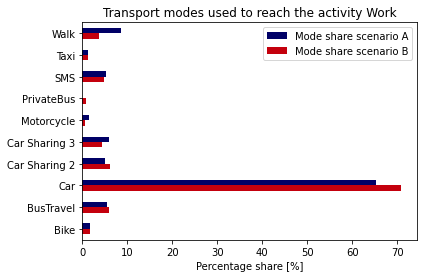

In [34]:
# plot additional informative charts
df_activities_stats = get_percentage_mode_changes_for_activities(df_activities_A,
                                                                 df_activities_B,
                                                                 filter_activity = filter_activity)

**8. Optional**

Saving new map configuration (optional):  
(mind that current configuration files will be overwritten if stored with same filename in same folder!)